## ATAC + MULTIOME (males september 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

**r2py setup**

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
library(Signac)
library(cicero)

library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)
library(Seurat)
library(GenomeInfoDb)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

**Load data**

In [7]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_sept2021/"
experiment_prefix = 'males_'

In [8]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 54542 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Setup of cisTopic**

In [10]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
adata

View of AnnData object with n_obs × n_vars = 54542 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

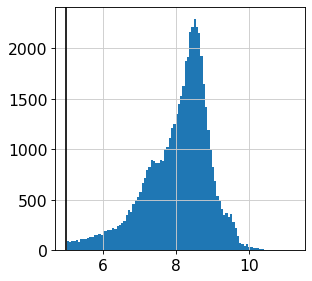

In [12]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5, color="black")

**Convert anndata to SingleCellExperiment**

In [13]:
%%R -i adata -i outdir -i experiment_prefix
adata
#saveRDS(adata, paste0(outdir, experiment_prefix, "_SCE.RDS"))

class: SingleCellExperiment 
dim: 184906 54542 
metadata(0):
assays(2): X binary_raw
rownames(184906): chr1:816748-817444 chr1:826607-827807 ...
  chrY:22727855-22728985 chrY:26408738-26409779
rowData names(16): peak_width exon ... total_counts log1p_total_counts
colnames(54542): 03-AAACGAAAGCTGAGGT-1 03-AAACGAACAATCATCG-1 ...
  12-TTTGTGTGTTTAGAAG-1 12-TTTGTGTTCTCGTAGA-1
colData names(11): cellatac_clusters n_genes_by_counts ...
  multiome_GermCells multiome_Somatic
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [15]:
%%R -i outdir -i experiment_prefix

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_initialized_cisTopic.RDS"))

Run cisTopic with farm resources as VM doesn't have enough CPU/memory

In [16]:
#%%R -i outdir -i experiment_prefix

#topics_vec <- c(25:45)
#cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
#                                   seed = 1712, 
#                                   nCores = 21, 
#                                   iterations = 500
#                                  )
#
#saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

In [12]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_trainedCistopic.RDS"))

[1] "Are these CGS models? Please, use type=\"maximum\""


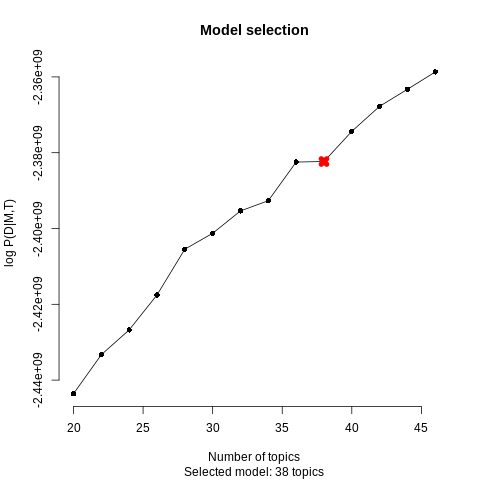

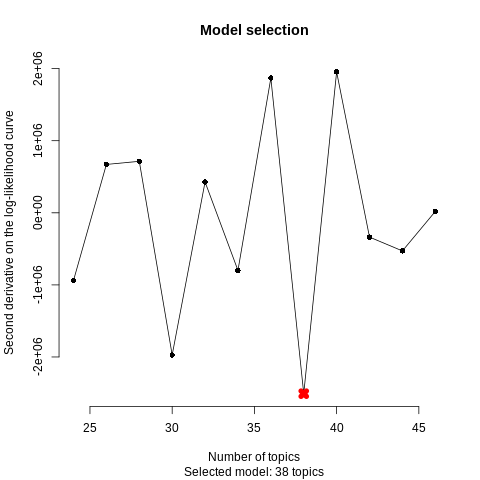

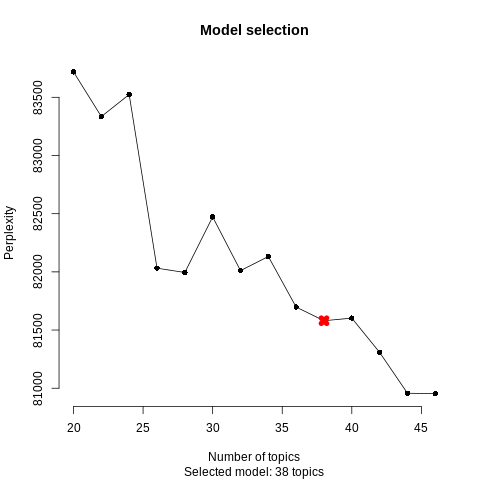

In [13]:
%%R

cistopic_model <- selectModel(cisTopicObject, select = 38)

In [14]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]    38 54542


In [15]:
topicXcell

array([[0.00106234, 0.01831433, 0.00880137, ..., 0.00420198, 0.00770208,
        0.04151153],
       [0.00107401, 0.00248031, 0.00476884, ..., 0.00540254, 0.0120216 ,
        0.01267019],
       [0.0003152 , 0.00014106, 0.01180223, ..., 0.00187147, 0.00077815,
        0.02895249],
       ...,
       [0.00029185, 0.00224521, 0.0027012 , ..., 0.00128884, 0.00038113,
        0.00197277],
       [0.11545646, 0.10791113, 0.08195205, ..., 0.00278955, 0.01338733,
        0.04278966],
       [0.00047864, 0.00152815, 0.00604452, ..., 0.03501059, 0.00235033,
        0.018005  ]])

In [16]:
adata.obsm['X_cistopic_38'] = topicXcell.T

**Visualize dimensionality reduction results**

In [21]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_cistopic_38")

In [22]:
sc.tl.umap(adata, min_dist = 0.4, spread = 1.2)

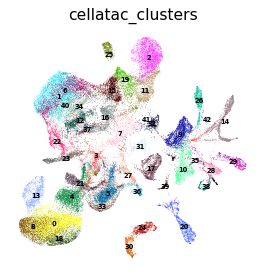

In [23]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)


In [24]:
colors = ['royalblue', 'orange', 'green', 'red', 'orchid', 'lightgrey', 'brown', 'pink', 'yellowgreen', 
                'deepskyblue']

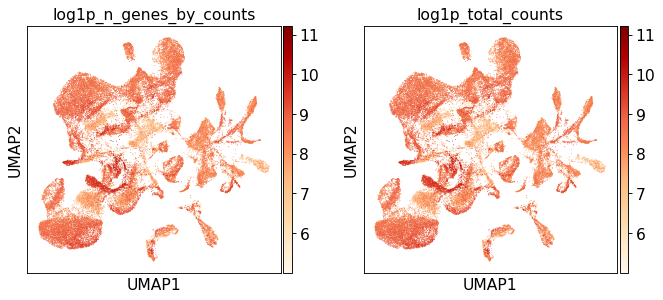

In [25]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

**Add metadata for females**

In [26]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

06    8513
02    6295
01    5787
13    5731
11    5427
08    5335
12    5264
07    4626
04    2872
10    1453
09    1410
03    1111
05     718
Name: code, dtype: int64

In [27]:
# Sample from code 
sample_dictionary = {'01' : 'HCA_F_GON10687819', '02' : 'HCA_F_GON10687820', '03' : 'FCA_GND8768481', 
                    '04' : 'FCA_GND8768482', '05' : 'FCA_GND8768487', '06' : 'FCA_GND8795927',
                     '07' : 'FCA_GND8795928', '08' : 'HD_F_GON9479872', '09' : 'HD_F_GON9525611', 
                     '10' : 'HD_F_GON9525612', '11' : 'FCA_GND9332157', '12' : 'HD_F_GON9883958',
                     '13' : 'HD_F_GON9883955'
                    }
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

FCA_GND8795927       8513
HCA_F_GON10687820    6295
HCA_F_GON10687819    5787
HD_F_GON9883955      5731
FCA_GND9332157       5427
HD_F_GON9479872      5335
HD_F_GON9883958      5264
FCA_GND8795928       4626
FCA_GND8768482       2872
HD_F_GON9525612      1453
HD_F_GON9525611      1410
FCA_GND8768481       1111
FCA_GND8768487        718
Name: sample, dtype: int64

... storing 'code' as categorical
... storing 'sample' as categorical


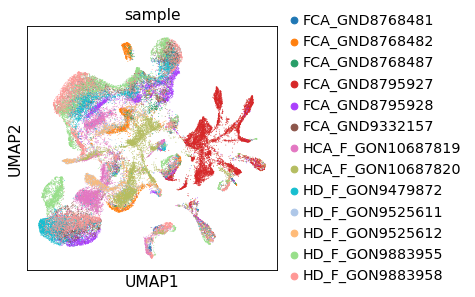

In [28]:
sc.pl.umap(adata, color = 'sample')

In [29]:
sex_dictionary = {'HCA_F_GON10687819' : 'male', 'HCA_F_GON10687820' : 'male', 'FCA_GND8768481' : 'male', 
                   'FCA_GND8768482' : 'male', 'FCA_GND8768487' : 'male', 'FCA_GND8795927' : 'male',
                     'FCA_GND8795928' : 'male', 'HD_F_GON9479872' : 'male', 'HD_F_GON9525611' : 'male', 
                     'HD_F_GON9525612' : 'male', 'FCA_GND9332157' : 'male', 'HD_F_GON9883958' : 'male',
                     'HD_F_GON9883955' : 'male'}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

male    54542
Name: sex, dtype: int64

In [30]:
stage_dictionary = {'HCA_F_GON10687819' : '19 PCW', 'HCA_F_GON10687820' : '8.8 PCW', 'FCA_GND8768481' : '19 PCW', 
                   'FCA_GND8768482' : '9 PCW', 'FCA_GND8768487' : '12 PCW', 'FCA_GND8795927' : '7 PCW',
                     'FCA_GND8795928' : '12 PCW', 'HD_F_GON9479872' : '15 PCW', 'HD_F_GON9525611' : '12 PCW', 
                     'HD_F_GON9525612' : '12 PCW', 'FCA_GND9332157' : '17 PCW', 'HD_F_GON9883958' : '21 PCW',
                     'HD_F_GON9883955' : '17 PCW'}
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

17 PCW     11158
7 PCW       8513
12 PCW      8207
19 PCW      6898
8.8 PCW     6295
15 PCW      5335
21 PCW      5264
9 PCW       2872
Name: stage, dtype: int64

In [31]:
individual_dictionary = {'HCA_F_GON10687819' : 'Hrv3', 'HCA_F_GON10687820' : 'Hrv41', 'FCA_GND8768481' : 'Hrv3', 
                   'FCA_GND8768482' : 'Hrv10', 'FCA_GND8768487' : 'Hrv15', 'FCA_GND8795927' : 'Hrv17',
                     'FCA_GND8795928' : 'Hrv18', 'HD_F_GON9479872' : 'Hrv40', 'HD_F_GON9525611' : 'Hrv15', 
                     'HD_F_GON9525612' : 'Hrv15', 'FCA_GND9332157' : 'Hrv21', 'HD_F_GON9883958' : 'Hrv54',
                     'HD_F_GON9883955' : 'Hrv55'}
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

Hrv17    8513
Hrv3     6898
Hrv41    6295
Hrv55    5731
Hrv21    5427
Hrv40    5335
Hrv54    5264
Hrv18    4626
Hrv15    3581
Hrv10    2872
Name: individual, dtype: int64

#### Plot metadata information

... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


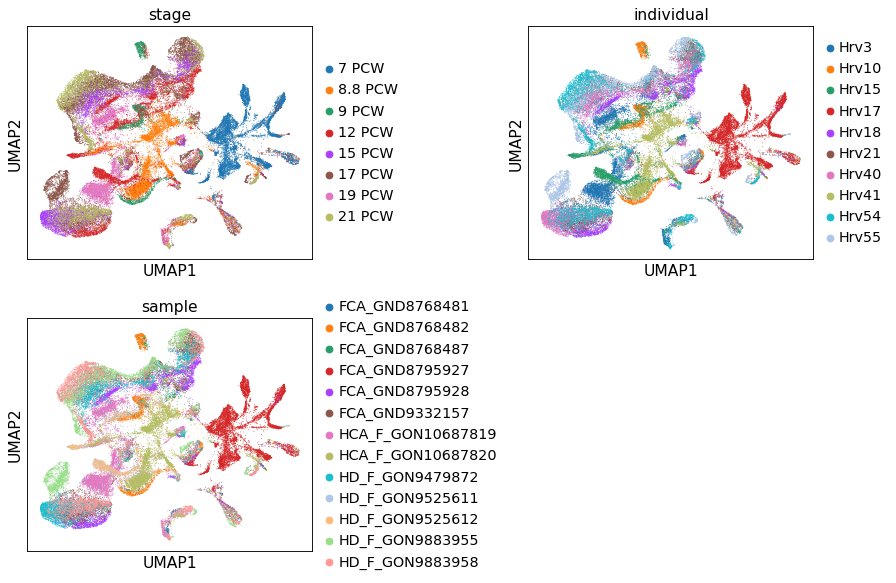

In [32]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.6)

#### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the paper:

cisTopic calculates the predictive distribution, which describes the probability of each region in each cell, by multiplying the topic–cell and the region–topic distributions:
𝑃(𝑟𝑖|𝑐𝑗)=∑𝑘=1𝐾𝑃(𝑟𝑖|𝑇𝑘)𝑃(𝑇𝑘|𝑐𝑗)
 
where

 * 𝑃(𝑟𝑖|𝑐𝑗)  is the probability of region i in cell j,
 * 𝑃(𝑟𝑖|𝑇𝑘)  is the probability of region i in topic k, and
 * 𝑃(𝑇𝑘|𝑐𝑗)  is the probability of topic k in cell j.

In [33]:
#%%R 

#install.packages("bigmemory")

In [17]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [18]:
%%R
dim(p_mat)

[1] 184906  54542


In [19]:
p_mat

array([[6.13334990e-06, 5.62042680e-06, 3.91478230e-06, ...,
        2.64010627e-06, 1.18751575e-06, 4.71593623e-06],
       [5.06671636e-05, 4.26778875e-05, 3.14780557e-05, ...,
        4.74443547e-05, 3.20676335e-05, 2.21620340e-05],
       [1.83813520e-07, 2.57246202e-07, 1.34547691e-06, ...,
        1.53563925e-07, 7.58989454e-08, 3.66070556e-07],
       ...,
       [7.09189796e-05, 6.34661553e-05, 4.85858764e-05, ...,
        5.87514017e-05, 6.22297745e-05, 3.50240159e-05],
       [9.39896393e-06, 1.08585033e-05, 5.99051855e-06, ...,
        1.23809270e-06, 1.13677865e-06, 4.56023049e-06],
       [7.18849495e-07, 4.32104364e-07, 2.75205099e-06, ...,
        5.85015239e-07, 1.82300177e-07, 2.92891572e-06]])

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [20]:
adata.layers["cistopic_p"] = p_mat.T

#### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in Bravo Gonzales-Blas et al. 2020). This is very useful to check out accessibility of marker genes for example. From the paper:

we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in GenomicRanges and Signac. Here I use peaks within a 5kb window of a gene (d parameter)

In [38]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [39]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  print("Got to here")
  print(typeof(length(all_peaks)))
  print(typeof(length(all_feats)))
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [40]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [41]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

[1] "Got to here"
[1] "integer"
[1] "integer"


In [42]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

### Alternative implementation of dot product between *adj_mat* and *p_mat*

In [43]:
print(np.__version__)

1.21.2


In [44]:
import math

#### adj_mat

In [45]:
rows_adj_mat = adj_mat.shape[0]
print(rows_adj_mat)
cols_adj_mat = adj_mat.shape[1]
print(cols_adj_mat)

19085
184906


In [46]:
a1 = adj_mat[0:math.ceil(rows_adj_mat/2), 0:math.ceil(cols_adj_mat/2)]
a2 = adj_mat[0:math.ceil(rows_adj_mat/2), math.ceil(cols_adj_mat/2):]
a3 = adj_mat[math.ceil(rows_adj_mat/2):, 0:math.ceil(cols_adj_mat/2)]
a4 = adj_mat[math.ceil(rows_adj_mat/2):, math.ceil(cols_adj_mat/2):]

In [47]:
print("a1 : {}\na2 : {}\na3 : {}\na4 : {}".format(a1.shape, a2.shape, a3.shape, a4.shape))

a1 : (9543, 92453)
a2 : (9543, 92453)
a3 : (9542, 92453)
a4 : (9542, 92453)


#### p_mat

In [48]:
rows_p_mat = p_mat.shape[0]
print(rows_p_mat)
cols_p_mat = p_mat.shape[1]
print(cols_p_mat)

184906
54542


In [49]:
b1 = p_mat[0:math.ceil(rows_p_mat/2), 0:math.ceil(cols_p_mat/2)]
b2 = p_mat[0:math.ceil(rows_p_mat/2), math.ceil(cols_p_mat/2):]
b3 = p_mat[math.ceil(rows_p_mat/2):, 0:math.ceil(cols_p_mat/2)]
b4 = p_mat[math.ceil(rows_p_mat/2):, math.ceil(cols_p_mat/2):]

In [50]:
print("b1 : {}\nb2 : {}\nb3 : {}\nb4 : {}".format(b1.shape, b2.shape, b3.shape, b4.shape))

b1 : (92453, 27271)
b2 : (92453, 27271)
b3 : (92453, 27271)
b4 : (92453, 27271)


#### Strassen matrix multiplication

In [51]:
c1 = np.add(a1.dot(b1), a2.dot(b3))

In [52]:
c1.shape

(9543, 27271)

In [53]:
c2 = np.add(a1.dot(b2), a2.dot(b4))

In [54]:
c2.shape

(9543, 27271)

In [55]:
c3 = np.add(a3.dot(b1), a4.dot(b3))

In [56]:
c3.shape

(9542, 27271)

In [57]:
c4 = np.add(a3.dot(b2), a4.dot(b4))

In [58]:
c4.shape

(9542, 27271)

In [59]:
c12 = np.concatenate((c1, c2), axis=1)

In [60]:
c12.shape

(9543, 54542)

In [61]:
c34 = np.concatenate((c3, c4), axis=1)

In [62]:
c34.shape

(9542, 54542)

In [63]:
gene_mat = np.concatenate((c12, c34), axis=0)

In [64]:
gene_mat.shape

(19085, 54542)

In [65]:
gene_mat

array([[5.25484945e-05, 4.43720447e-05, 3.54956716e-05, ...,
        5.09125318e-05, 3.59861753e-05, 2.66460549e-05],
       [4.93215213e-05, 4.17529475e-05, 3.75249199e-05, ...,
        2.80849122e-05, 1.92359839e-05, 3.11120335e-05],
       [4.93215213e-05, 4.17529475e-05, 3.75249199e-05, ...,
        2.80849122e-05, 1.92359839e-05, 3.11120335e-05],
       ...,
       [4.01613083e-05, 4.15098158e-05, 2.57209693e-05, ...,
        2.34976174e-05, 1.81474712e-05, 2.14300844e-05],
       [8.49625391e-07, 1.07211453e-06, 4.69245148e-06, ...,
        2.58516638e-06, 5.91777527e-06, 5.63227782e-06],
       [1.50085015e-05, 1.51805284e-05, 1.32245334e-05, ...,
        1.68813950e-06, 2.40830568e-06, 1.17343470e-05]])

In [66]:
# gene_mat = adj_mat.dot(p_mat) --> kills the kernel because both matrices need to be hold in memory 

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [67]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [68]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

gene_id
gene_name                    
LINC01128     ENSG00000228794
FAM41C        ENSG00000230368
TUBB8P11      ENSG00000234711
FAM166AP3     ENSG00000283040
RP11-54O7.16  ENSG00000272438

In [69]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(54542, 19085)

In [70]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 54542 × 19085
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [71]:
gene_adata.var_names_make_unique()

In [73]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_38'] = topicXcell.T

In [77]:
adata

AnnData object with n_obs × n_vars = 54542 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors'
    obsm: 'X_cistopic_38', 'X_umap'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [78]:
del adata.layers['cistopic_p']

In [79]:
adata

AnnData object with n_obs × n_vars = 54542 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors'
    obsm: 'X_cistopic_38', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

**Save anndata objects**

In [80]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [81]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

**Proceed with gene_data to look at marker genes**

In [82]:
sc.pp.neighbors(gene_adata, n_neighbors=15, use_rep="X_cistopic_38")

In [83]:
sc.tl.umap(gene_adata, min_dist = 0.4, spread = 1.2)

**Plot markers per cell type from RNA-seq**

In [84]:
mesothelial = ['LRRN4', 'UPK3B', 'KLK11'] 
gonad_somatic_cells = ['NR5A1', 'AMHR2', 'MIR202HG'] 
supporting = ['WNT6', 'WIPF3']
supporting_LGR5 = ['LGR5']
supporting_PAX8 = ['PAX8']
preGranulosa_lineage = ["KITLG",  'RSPO1', 'OSR1' , 'NR4A1']
granulosa_lineage = ['FOXL2', 'IRX3', 'CYP19A1', 'RDH10']
sertoli_lineage = ['SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3']
mesenchymal_steroidogenic = ['CYP11A1', 'CYP17A1', 'STAR',  'MGARP', 'FDXR']
leydigFetal_lineage = ['FDX1'] # Not there
leydig_lineage = ['INSL3', 'GLI1', 'HHIP', 'PTCH2']
preTheca_lineage = ['KIT', 'LHCGR'] # Not there
mesenchymal = ['DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN']
gonadal_mesenchymal = ['LHX9', 'GATA4']
ovary_stroma = ['SPRR2F', 'AKR1C1', 'DIRAS3'] # Not there
testis_border_mesenhyme = ['IGF1', 'FGL2', 'PCSK2', 'ANGPTL1']
testis_myoid= ['PTCH1', 'NGFR', 'MSC', 'NEFL']
extragonadal_mesen = ['GATA2', 'NR2F1', 'WNT4', 'RSPO3', 'MEIS1', 'FAP']
mesoneprhic_stroma = ['CRABP1', 'ALX1',  'FOXD1']
gonad_dev = ['EMX2', 'WT1']
muscoskeletal = ['MYF5','PAX7','MYF6', 'MYLPF']
epithelial = ["EPCAM"]
PGCs= ['POU5F1', 'NANOG', 'NANOS3']
GCs = ['DAZL', 'DDX4']
immunePGCs= ['PTPRC']
endothelial = ['PECAM1', 'VWF', 'CDH5']
erythroid = ["GYPC", "HBA1"]
neural = ['ASCL1', 'ELAVL4']
PV = ["PDGFRB", 'ACTA2']
cycling = ['CDK1', 'MKI67'] # Not there
quiescent = ['CDKN1B']
male = ['SRY', 'RPS4Y1','DDX3Y'] # Not there

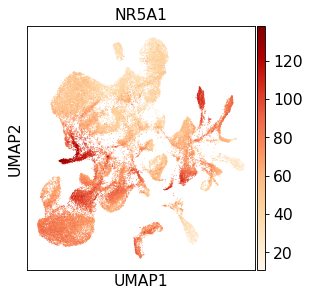

In [86]:
# Gonadal somatic
sc.pl.umap(gene_adata, color = ['NR5A1'] , ncols = 3, color_map = 'OrRd')

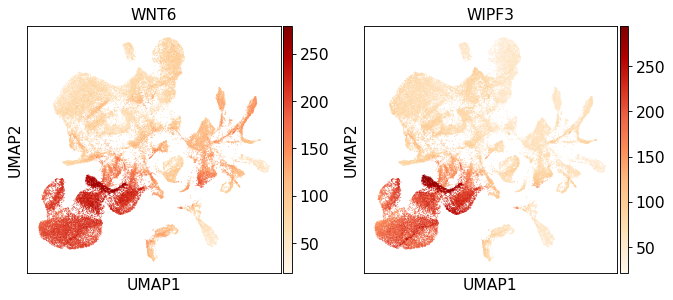

In [87]:
sc.pl.umap(gene_adata, color = supporting, ncols = 3, color_map = 'OrRd')

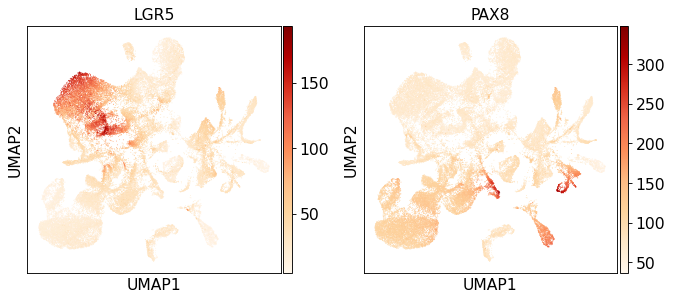

In [88]:
sc.pl.umap(gene_adata, color = ['LGR5', 'PAX8'], ncols = 3, color_map = 'OrRd')

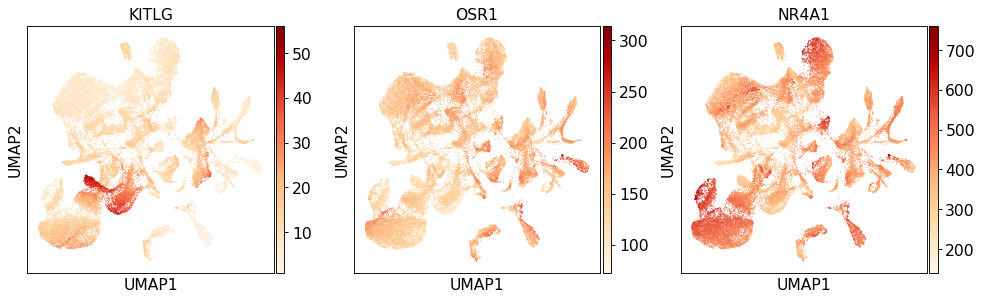

In [89]:
# Pregranulosa
sc.pl.umap(gene_adata, color = ["KITLG", 'OSR1' , 'NR4A1'], ncols = 3, color_map = 'OrRd')

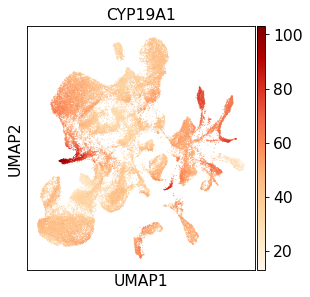

In [90]:
# Granulosa 
sc.pl.umap(gene_adata, color = ['CYP19A1'], ncols = 2, color_map = 'OrRd')

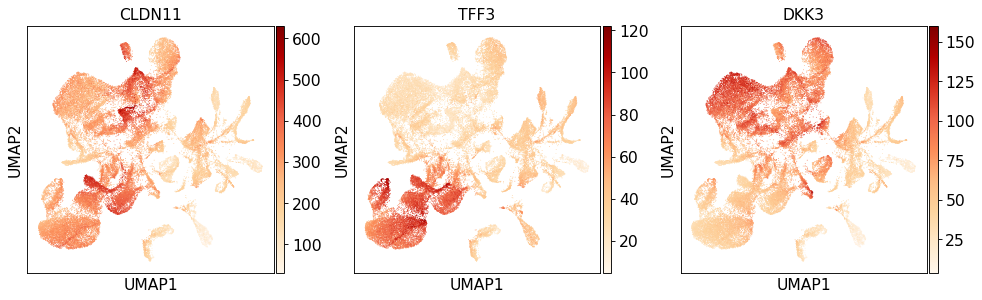

In [91]:
# Sertoli lineage
sc.pl.umap(gene_adata, color = [ 'CLDN11', 'TFF3', 'DKK3'], ncols = 3, color_map = 'OrRd')

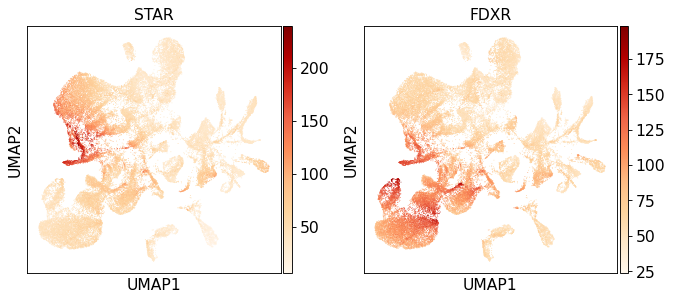

In [92]:
# Steroidogenic mesenchymal 
sc.pl.umap(gene_adata, color = ['STAR',  'FDXR'], ncols = 3, color_map = 'OrRd')

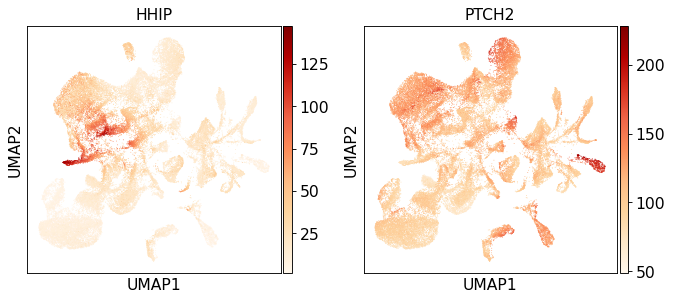

In [93]:
# Leydig lineage
sc.pl.umap(gene_adata, color = ['HHIP', 'PTCH2'], ncols = 3, color_map = 'OrRd')

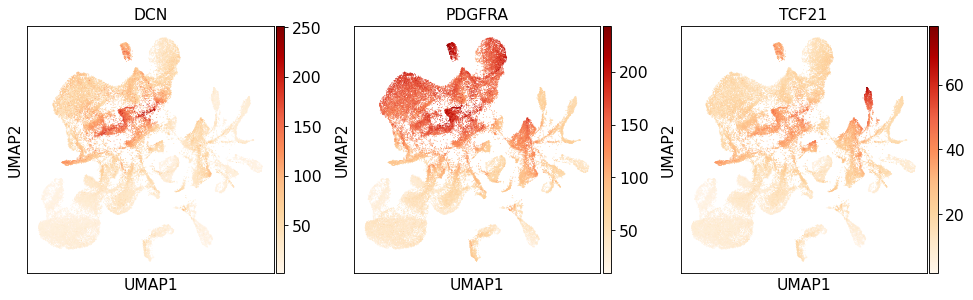

In [94]:
# Mesenchymal 
sc.pl.umap(gene_adata, color = ['DCN', 'PDGFRA','TCF21'], ncols = 3, color_map = 'OrRd')

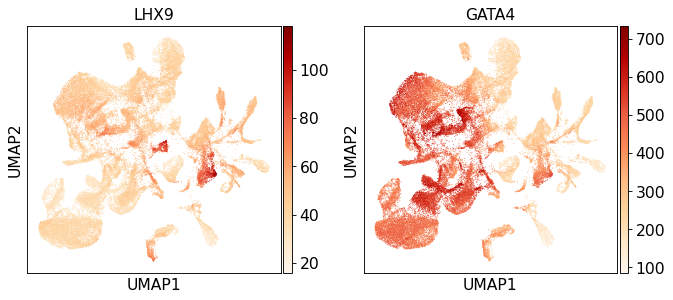

In [95]:
# Gonadal mesenchymal 
sc.pl.umap(gene_adata, color = ['LHX9', 'GATA4'], ncols = 3, color_map = 'OrRd')

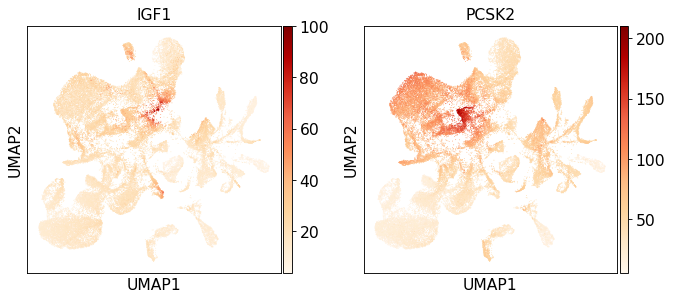

In [96]:
# Testis border mesenchyme
sc.pl.umap(gene_adata, color = ['IGF1', 'PCSK2'], ncols = 3, color_map = 'OrRd')

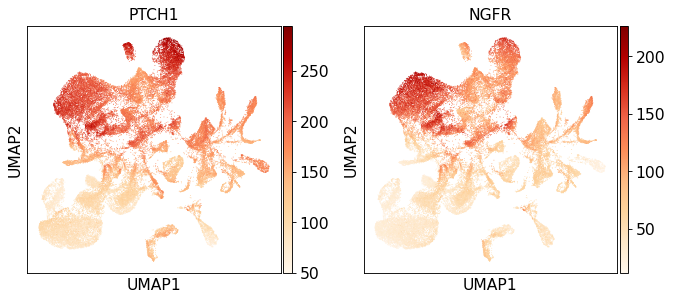

In [97]:
# Testis myoid
sc.pl.umap(gene_adata, color = ['PTCH1', 'NGFR'], ncols = 3, color_map = 'OrRd')

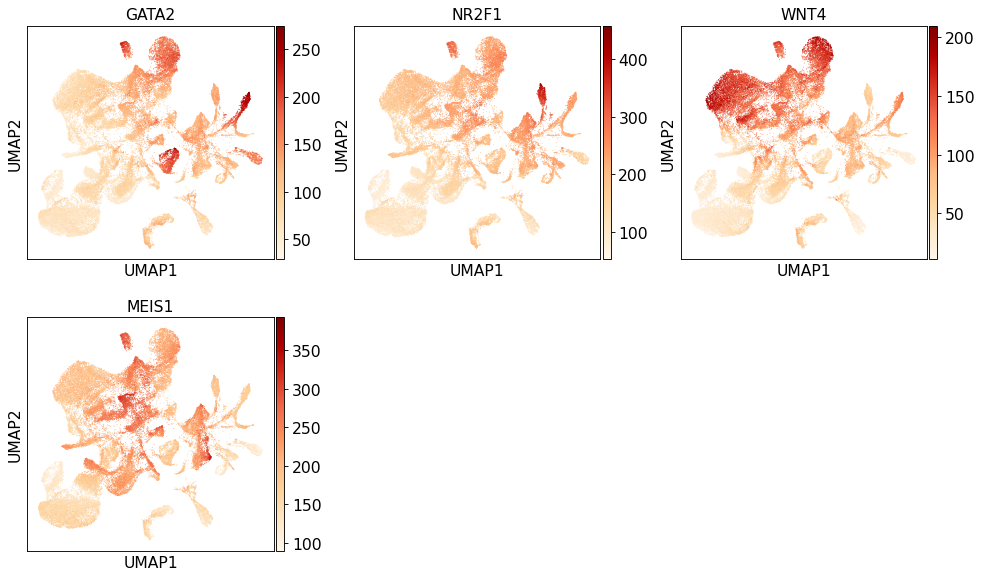

In [98]:
# Extragonal mesenchymal 
sc.pl.umap(gene_adata, color = ['GATA2', 'NR2F1', 'WNT4',  'MEIS1'], ncols = 3, color_map = 'OrRd')

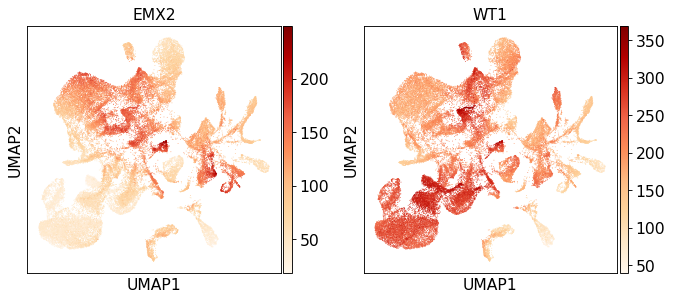

In [99]:
# Gonad dev
sc.pl.umap(gene_adata, color = ['EMX2', 'WT1'], ncols = 3, color_map = 'OrRd')

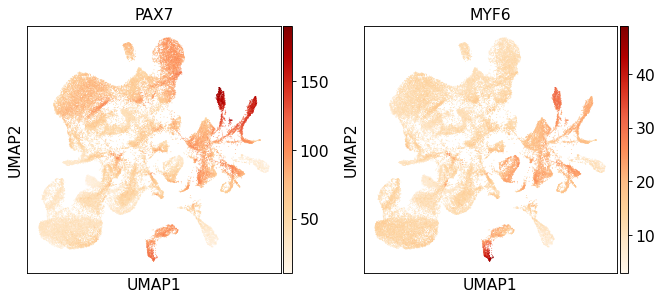

In [100]:
# Muscoskeletal 
sc.pl.umap(gene_adata, color = ['PAX7','MYF6'], ncols = 3, color_map = 'OrRd')

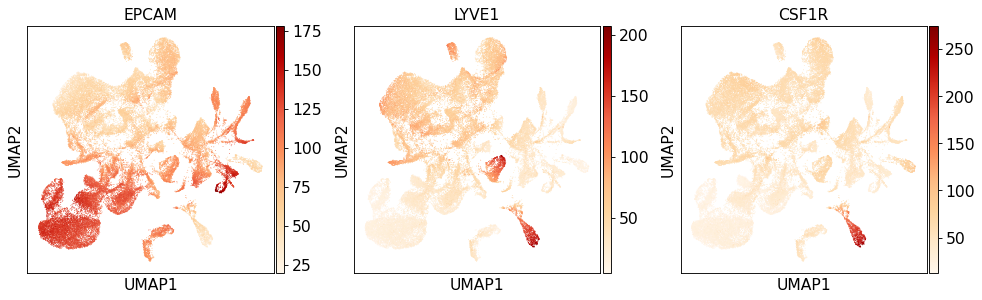

In [101]:
# Epithelial and immune
sc.pl.umap(gene_adata, color = [ 'EPCAM',  'LYVE1', 'CSF1R' 
                                                           ], ncols = 3, color_map = 'OrRd')

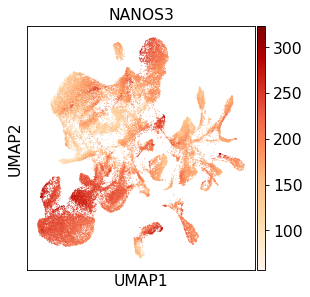

In [102]:
# PGC
sc.pl.umap(gene_adata, color = [ 'NANOS3'], ncols = 3, color_map = 'OrRd')

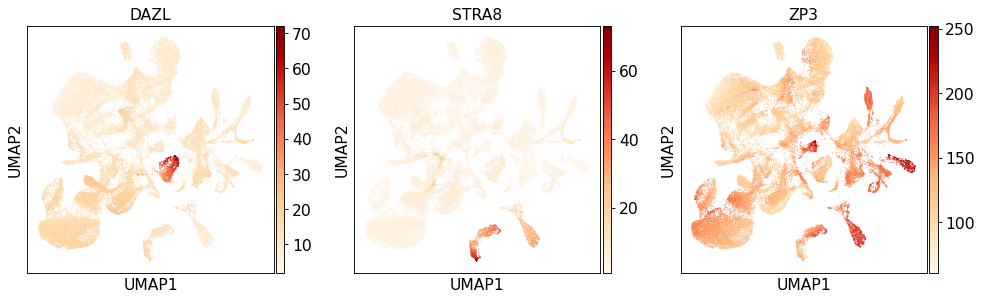

In [103]:
# Germ cells
sc.pl.umap(gene_adata, color = ['DAZL',  'STRA8', 'ZP3'], ncols = 3, color_map = 'OrRd')

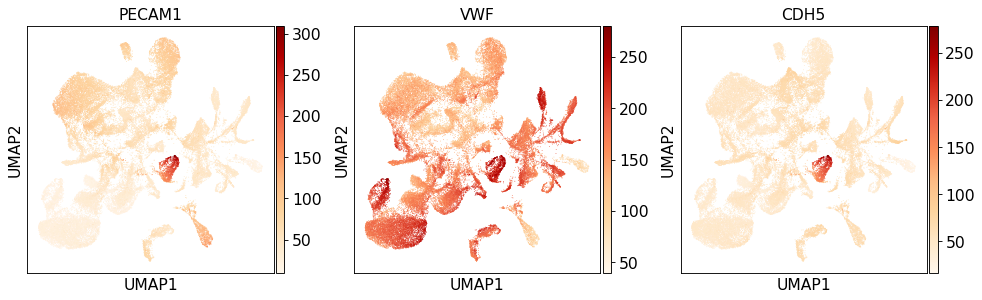

In [104]:
# Endothelial
sc.pl.umap(gene_adata, color = ['PECAM1', 'VWF', 'CDH5'], ncols = 3, color_map = 'OrRd')

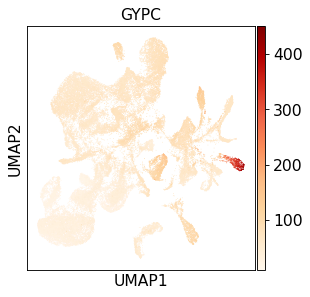

In [105]:
# Erythroid
sc.pl.umap(gene_adata, color = ["GYPC"], ncols = 3, color_map = 'OrRd')

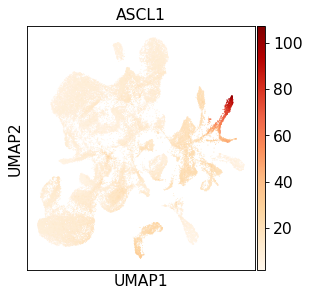

In [106]:
# Neural
sc.pl.umap(gene_adata, color = ['ASCL1'], ncols = 3, color_map = 'OrRd')

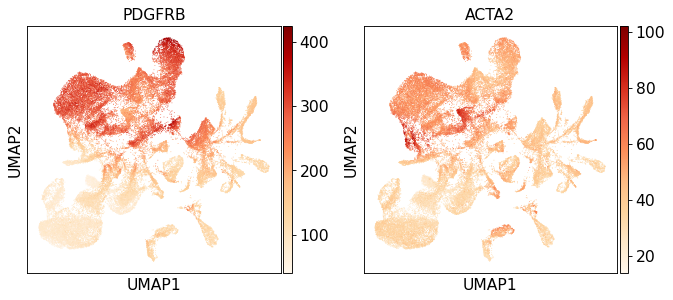

In [107]:
# Perivascular
sc.pl.umap(gene_adata, color = ["PDGFRB", 'ACTA2'], ncols = 3, color_map = 'OrRd')

In [108]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

## Compute CCANs enriched in each cell type

In [21]:
p_mat_transpose = p_mat.T 

In [22]:
ccans = pd.read_csv(outdir + experiment_prefix + "_ccans_annotated.csv", index_col = 0)
ccans = pd.DataFrame(ccans)
ccans.head()

Peak  CCAN           peaks_formatted  peak_width  exon  \
1  chr1-100048186-100049074     1  chr1-100048186-100049074         889     0   
2  chr1-100127012-100127821     1  chr1-100127012-100127821         810     0   
3    chr1-10012744-10013234   623    chr1-10012744-10013234         491     0   
4  chr1-100132297-100133517     1  chr1-100132297-100133517        1221     1   
5      chr1-1001624-1002093   662      chr1-1001624-1002093         470     0   

           gene_id  gene gene_name annotation  promoter  tss_distance  \
1  ENSG00000156875     1   MFSD14A     intron         0          9596   
2  ENSG00000156876     1     SASS6     intron         0          5133   
3  ENSG00000162444     1      RBP7     intron         0         15527   
4  ENSG00000122435     1    TRMT13       exon         1             0   
5  ENSG00000187608     1     ISG15   promoter         1           478   

   ENCODE_blacklist  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0

Workflow: 

 * Subset the cells x peaks matrix to keep only the peaks in CCANs
 * Create a new matrix: cell_type x CCANs 
 * Normalize new matrix by CCAN

In [23]:
peaksinCCANs = list(ccans['Peak'])

In [24]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]
cistopic = pd.DataFrame(p_mat_transpose, index=adata.obs_names, columns=adata.var['peaks_formatted'])
cistopic.head()

peaks_formatted        chr1-816748-817444  chr1-826607-827807  \
03-AAACGAAAGCTGAGGT-1            0.000006            0.000051   
03-AAACGAACAATCATCG-1            0.000006            0.000043   
03-AAACGAACATGCACTA-1            0.000004            0.000031   
03-AAACTCGTCACCCGGA-1            0.000006            0.000041   
03-AAACTGCCAAGGGTAC-1            0.000002            0.000042   

peaks_formatted        chr1-842637-843180  chr1-858058-859045  \
03-AAACGAAAGCTGAGGT-1        1.838135e-07            0.000002   
03-AAACGAACAATCATCG-1        2.572462e-07            0.000001   
03-AAACGAACATGCACTA-1        1.345477e-06            0.000003   
03-AAACTCGTCACCCGGA-1        2.451028e-07            0.000002   
03-AAACTGCCAAGGGTAC-1        1.956410e-07            0.000004   

peaks_formatted        chr1-868834-869154  chr1-869371-870234  \
03-AAACGAAAGCTGAGGT-1            0.000007            0.000027   
03-AAACGAACAATCATCG-1            0.000007            0.000021   
03-AAACGAACATGCACTA-1            0.000004            0.000021   
03-AAACTCGTCACCCGGA-1            0.000007            0.000026   
03-AAACTGCCAAGGGTAC-1            0.000001            0.000017   

peaks_formatted        chr1-875067-875919  chr1-876133-877534  \
03-AAACGAAAGCTGAGGT-1            0.000004            0.000010   
03-AAACGAACAATCATCG-1            0.000005            0.000009   
03-AAACGAACATGCACTA-1            0.000004            0.000009   
03-AAACTCGTCACCCGGA-1            0.000005            0.000009   
03-AAACTGCCAAGGGTAC-1            0.000006            0.000010   

peaks_formatted        chr1-901224-901648  chr1-916388-917645  ...  \
03-AAACGAAAGCTGAGGT-1            0.000008            0.000009  ...   
03-AAACGAACAATCATCG-1            0.000007            0.000011  ...   
03-AAACGAACATGCACTA-1            0.000004            0.000011  ...   
03-AAACTCGTCACCCGGA-1            0.000007            0.000011  ...   
03-AAACTGCCAAGGGTAC-1            0.000002            0.000018  ...   

peaks_formatted        chrY-19002844-19003860  chrY-19045789-19046906  \
03-AAACGAAAGCTGAGGT-1                0.000007            4.562184e-07   
03-AAACGAACAATCATCG-1                0.000007            5.155387e-07   
03-AAACGAACATGCACTA-1                0.000005            2.801214e-06   
03-AAACTCGTCACCCGGA-1                0.000007            5.313039e-07   
03-AAACTGCCAAGGGTAC-1                0.000005            2.794166e-07   

peaks_formatted        chrY-19066186-19067095  chrY-19566682-19568068  \
03-AAACGAAAGCTGAGGT-1                0.000003                0.000078   
03-AAACGAACAATCATCG-1                0.000003                0.000071   
03-AAACGAACATGCACTA-1                0.000002                0.000051   
03-AAACTCGTCACCCGGA-1                0.000003                0.000062   
03-AAACTGCCAAGGGTAC-1                0.000001                0.000069   

peaks_formatted        chrY-19572623-19573139  chrY-19743945-19745337  \
03-AAACGAAAGCTGAGGT-1            6.549086e-06                0.000033   
03-AAACGAACAATCATCG-1            6.130823e-06                0.000027   
03-AAACGAACATGCACTA-1            4.659942e-06                0.000026   
03-AAACTCGTCACCCGGA-1            6.452375e-06                0.000026   
03-AAACTGCCAAGGGTAC-1            8.872910e-07                0.000027   

peaks_formatted        chrY-20559662-20560783  chrY-20574999-20576299  \
03-AAACGAAAGCTGAGGT-1            9.982928e-07                0.000071   
03-AAACGAACAATCATCG-1            1.240855e-06                0.000063   
03-AAACGAACATGCACTA-1            2.039520e-06                0.000049   
03-AAACTCGTCACCCGGA-1            1.244833e-06                0.000057   
03-AAACTGCCAAGGGTAC-1            1.339606e-06                0.000054   

peaks_formatted        chrY-22727855-22728985  chrY-26408738-26409779  
03-AAACGAAAGCTGAGGT-1                0.000009            7.188495e-07  
03-AAACGAACAATCATCG-1                0.000011            4.321044e-07  
03-AAACGAACATGCACTA-1                0.0000

In [25]:
cells_peaksinCCANs = cistopic.loc[:, peaksinCCANs]
cells_peaksinCCANs.shape

(54542, 61586)

In [26]:
annots = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

barcodes = list(annots.obs_names)
cells_peaksinCCANs = cells_peaksinCCANs.loc[barcodes, :]

In [27]:
cells_peaksinCCANs.shape

(52285, 61586)

In [28]:
# Mapping of cells to cell types 
annots.obs['barcode'] = annots.obs_names
cells_celltypes = annots.obs[['barcode', 'somatic_annotation']]
cells_celltypes.head()

barcode somatic_annotation
03-AAACGAAAGCTGAGGT-1  03-AAACGAAAGCTGAGGT-1            Sertoli
03-AAACGAACAATCATCG-1  03-AAACGAACAATCATCG-1            Sertoli
03-AAACGAACATGCACTA-1  03-AAACGAACATGCACTA-1            Sertoli
03-AAACTCGTCACCCGGA-1  03-AAACTCGTCACCCGGA-1            Sertoli
03-AAACTGCCAAGGGTAC-1  03-AAACTGCCAAGGGTAC-1       CoelEpi_LHX9

In [29]:
cells_mapping = cells_celltypes.groupby('somatic_annotation').groups

In [30]:
# Mean by rows 
for key in cells_mapping: 
    print(key)
    cells_peaksinCCANs.loc[key] = cells_peaksinCCANs.loc[cells_mapping[key]].mean(axis = 0)

CoelEpi_GATA2
CoelEpi_LHX9
Endothelial
Epithelial
Erythroid
FetalLeydig
GermCells
Gi
Immune
Mesenchymal_GATA2
Neural
PV
Sertoli
Ti
early_supporting
sPAX8


In [31]:
cells_peaksinCCANs.tail()

peaks_formatted   chr1-100048186-100049074  chr1-100127012-100127821  \
PV                                0.000002                  0.000002   
Sertoli                           0.000009                  0.000019   
Ti                                0.000001                  0.000002   
early_supporting                  0.000004                  0.000008   
sPAX8                             0.000003                  0.000005   

peaks_formatted   chr1-10012744-10013234  chr1-100132297-100133517  \
PV                          1.273563e-06                  0.000092   
Sertoli                     6.742063e-06                  0.000084   
Ti                          7.984022e-07                  0.000081   
early_supporting            2.170182e-06                  0.000090   
sPAX8                       2.196303e-06                  0.000091   

peaks_formatted   chr1-1001624-1002093  chr1-100249061-100250283  \
PV                            0.000048                  0.000094   
Sertoli                       0.000028                  0.000073   
Ti                            0.000033                  0.000075   
early_supporting              0.000031                  0.000081   
sPAX8                         0.000031                  0.000077   

peaks_formatted   chr1-100265517-100266895  chr1-10031496-10031810  \
PV                                0.000050                0.000002   
Sertoli                           0.000047                0.000011   
Ti                                0.000046                0.000002   
early_supporting                  0.000064                0.000007   
sPAX8                             0.000055                0.000005   

peaks_formatted   chr1-100354903-100355206  chr1-100364322-100365277  ...  \
PV                                0.000002                  0.000002  ...   
Sertoli                           0.000014                  0.000008  ...   
Ti                                0.000002                  0.000001  ...   
early_supporting                  0.000007                  0.000005  ...   
sPAX8                             0.000008                  0.000006  ...   

peaks_formatted   chrY-12537051-12538007  chrY-12642840-12644197  \
PV                              0.000002            1.108092e-06   
Sertoli                         0.000010            7.188832e-06   
Ti                              0.000001            9.772372e-07   
early_supporting                0.000005            3.596033e-06   
sPAX8                           0.000004            3.024330e-06   

peaks_formatted   chrY-12732904-12733984  chrY-12740980-12741783  \
PV                          7.323668e-07            6.854695e-07   
Sertoli                     4.900475e-06            6.054234e-06   
Ti                          7.524472e-07            6.994590e-07   
early_supporting            2.351678e-06            2.400395e-06   
sPAX8                       2.318667e-06            1.831781e-06   

peaks_formatted   chrY-12800220-12801282  chrY-13000240-13001174  \
PV                              0.000002            7.087822e-07   
Sertoli                         0.000008            5.960533e-06   
Ti                              0.000002            5.800194e-07   
early_supporting                0.000004            3.092958e-06   
sPAX8                           0.000006            4.599274e-06   

peaks_formatted   chrY-13210636-13211939  chrY-13434991-13436446  \
PV                              0.000004                0.000002   
Sertoli                         0.000026                0.000009   
Ti                              0.000004                0.000001   
early_supporting                0.000014                0.000005   
sPAX8                           0.000010                0.000007   

peaks_formatted   chrY-13442530-13443616  chrY-13551196-13551686  
PV                          1.045928e-06            8.175754e-08  
Sertoli                     6.668244e-06            1.136237e-07  
Ti              

In [33]:
rows_celltypes = list(np.unique(cells_celltypes['somatic_annotation']))
print(rows_celltypes)
# Select only aggregated rows
cells_peaksinCCANs = cells_peaksinCCANs.loc[rows_celltypes, ]

['CoelEpi_GATA2', 'CoelEpi_LHX9', 'Endothelial', 'Epithelial', 'Erythroid', 'FetalLeydig', 'GermCells', 'Gi', 'Immune', 'Mesenchymal_GATA2', 'Neural', 'PV', 'Sertoli', 'Ti', 'early_supporting', 'sPAX8']


In [34]:
cells_peaksinCCANs

peaks_formatted    chr1-100048186-100049074  chr1-100127012-100127821  \
CoelEpi_GATA2                      0.000002                  0.000003   
CoelEpi_LHX9                       0.000002                  0.000003   
Endothelial                        0.000002                  0.000003   
Epithelial                         0.000002                  0.000003   
Erythroid                          0.000002                  0.000002   
FetalLeydig                        0.000003                  0.000006   
GermCells                          0.000004                  0.000004   
Gi                                 0.000002                  0.000004   
Immune                             0.000002                  0.000003   
Mesenchymal_GATA2                  0.000001                  0.000002   
Neural                             0.000002                  0.000003   
PV                                 0.000002                  0.000002   
Sertoli                            0.000009                  0.000019   
Ti                                 0.000001                  0.000002   
early_supporting                   0.000004                  0.000008   
sPAX8                              0.000003                  0.000005   

peaks_formatted    chr1-10012744-10013234  chr1-100132297-100133517  \
CoelEpi_GATA2                1.162930e-06                  0.000088   
CoelEpi_LHX9                 1.364543e-06                  0.000103   
Endothelial                  1.150140e-06                  0.000095   
Epithelial                   1.338847e-06                  0.000092   
Erythroid                    8.081218e-07                  0.000169   
FetalLeydig                  1.535307e-06                  0.000076   
GermCells                    1.868431e-06                  0.000092   
Gi                           1.537620e-06                  0.000088   
Immune                       9.170342e-07                  0.000119   
Mesenchymal_GATA2            8.680611e-07                  0.000085   
Neural                       2.347040e-06                  0.000090   
PV                           1.273563e-06                  0.000092   
Sertoli                      6.742063e-06                  0.000084   
Ti                           7.984022e-07                  0.000081   
early_supporting             2.170182e-06                  0.000090   
sPAX8                        2.196303e-06                  0.000091   

peaks_formatted    chr1-1001624-1002093  chr1-100249061-100250283  \
CoelEpi_GATA2                  0.000036                  0.000081   
CoelEpi_LHX9                   0.000033                  0.000094   
Endothelial                    0.000033                  0.000089   
Epithelial                     0.000033                  0.000079   
Erythroid                      0.000031                  0.000177   
FetalLeydig                    0.000025                  0.000068   
GermCells                      0.000032                  0.000085   
Gi                             0.000034                  0.000082   
Immune                         0.000031                  0.000094   
Mesenchymal_GATA2              0.000034                  0.000082   
Neural                         0.000030                  0.000081   
PV                             0.000048                  0.000094   
Sertoli                        0.000028                  0.000073   
Ti                             0.000033                  0.000075   
early_supporting               0.000031                  0.000081   
sPAX8                          0.000031                  0.000077   

peaks_formatted    chr1-100265517-100266895  chr1-10031496-10031810  \
CoelEpi_GATA2                      0.000050                0.000009   
CoelEpi_LHX9                       0.000059                0.000009   
Endothelial                        0.000055                0.000002   
Epithelial                         0.000057                0.000004   
Erythroid            

In [35]:
# Mapping of peaks to CCANs 
ccans = ccans.set_index('peaks_formatted')
peaks_ccans = ccans[['Peak', 'CCAN']]
peaks_mapping = peaks_ccans.groupby('CCAN').groups

In [36]:
# Mean by columns 
for key in peaks_mapping: 
    #print(key)
    cells_peaksinCCANs[key] = cells_peaksinCCANs[peaks_mapping[key]].mean(axis = 1)

In [37]:
cells_peaksinCCANs.shape

(16, 65606)

In [38]:
cols_ccans = list(np.unique(peaks_ccans['CCAN']))
# Select only aggregated rows and columns 
celltype_CCANs = cells_peaksinCCANs.loc[:, cols_ccans]

In [39]:
celltype_CCANs = celltype_CCANs.loc[(celltype_CCANs.sum(axis=1) != 0), (celltype_CCANs.sum(axis=0) != 0)]

In [40]:
celltype_CCANs.shape

(16, 4020)

In [41]:
# Normalize by column (CCAN)
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [42]:
celltype_CCANs_zscore.index

Index(['CoelEpi_GATA2', 'CoelEpi_LHX9', 'Endothelial', 'Epithelial',
       'Erythroid', 'FetalLeydig', 'GermCells', 'Gi', 'Immune',
       'Mesenchymal_GATA2', 'Neural', 'PV', 'Sertoli', 'Ti',
       'early_supporting', 'sPAX8'],
      dtype='object')

In [43]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['GermCells','CoelEpi_GATA2', 'CoelEpi_LHX9',  'early_supporting', 'sPAX8',
                                                      'Sertoli', 'Ti', 'FetalLeydig', 'Gi', 'Mesenchymal_GATA2',  'Endothelial', 'Immune',
                                                       'Epithelial',
       'Erythroid',  'Neural',])

In [44]:
celltype_CCANs_zscore

peaks_formatted        1         2         3         4         6         7     \
GermCells         -0.231268 -0.490969 -0.022162 -0.125923  3.872087 -0.363922   
CoelEpi_GATA2     -0.568746  0.499506 -0.546081 -0.312187 -0.260170  0.071062   
CoelEpi_LHX9       0.082325 -0.353005 -0.540907 -0.375583 -0.261003 -0.082796   
early_supporting   0.227576 -0.582904  0.203341 -0.013277 -0.234956 -0.320017   
sPAX8             -0.236499 -0.573324 -0.233710 -0.048037 -0.260897 -0.257112   
Sertoli            0.054976 -0.694336  0.739949 -0.268668 -0.212469 -0.585320   
Ti                -0.989319  3.098594 -0.597382 -0.642667 -0.294143  3.510830   
FetalLeydig       -0.786610 -0.174239  3.534326 -0.200221 -0.256447  0.021633   
Gi                -0.247638  0.193827 -0.280334 -0.184236 -0.238567  0.329446   
Mesenchymal_GATA2 -0.773535  1.254896 -0.667175 -0.531405 -0.269299  0.948745   
Endothelial       -0.227046 -0.588817 -0.496130  3.794810 -0.290698 -0.573793   
Immune             0.681545 -0.413854  0.605952  0.111740 -0.250737 -0.693112   
Epithelial         0.153792 -0.746079 -0.385531 -0.069772 -0.232067 -0.596412   
Erythroid          3.530907 -0.924685 -0.250945 -0.562218 -0.249005 -0.794228   
Neural            -0.244220 -0.437109 -0.492511 -0.243229 -0.285902 -0.197439   

peaks_formatted        9         10        15        16    ...      8010  \
GermCells         -0.449941 -0.063273  0.168087 -0.321052  ...  0.656196   
CoelEpi_GATA2      0.640679 -0.332989  0.631466 -0.108538  ... -0.413177   
CoelEpi_LHX9       0.078197 -0.327450 -0.048497 -0.248713  ... -0.407882   
early_supporting  -0.276338  0.760802  0.317119 -0.364752  ...  0.509500   
sPAX8             -0.343670  0.251158 -0.568046 -0.219027  ... -0.011967   
Sertoli           -0.778637  3.443208 -1.029268 -0.457069  ...  3.347303   
Ti                 2.957807 -0.676875 -0.765742  3.608091  ... -0.858700   
FetalLeydig       -0.330814  0.785310 -1.176067  0.131536  ... -0.170618   
Gi                 0.409841 -0.009359  0.312450  0.161586  ... -0.236494   
Mesenchymal_GATA2  1.750239 -0.662464 -0.428376  0.862117  ... -0.850262   
Endothelial       -0.706603 -0.507323  1.766839 -0.486373  ... -0.606843   
Immune            -0.664375 -0.620245 -1.363609 -0.614668  ... -0.700661   
Epithelial        -0.704062 -0.476665  0.940237 -0.464075  ... -0.249365   
Erythroid         -0.896062 -0.727920 -1.138991 -0.689673  ...  0.876556   
Neural            -0.253505 -0.323199  2.149578 -0.470259  ... -0.174660   

peaks_formatted        8013      8015      8016      8017      8018      8019  \
GermCells         -0.138627 -0.400878 -0.252467 -0.643149 -0.563589  0.057805   
CoelEpi_GATA2     -0.420040  0.821109 -0.628780  0.430758 -0.036586 -0.398141   
CoelEpi_LHX9      -0.115524 -0.283992 -0.449925 -0.087787 -0.197744 -0.390377   
early_supporting   0.772432 -0.475109  0.652160 -0.307786 -0.491886  0.822246   
sPAX8              0.790071 -0.473350  0.416080 -0.170848 -0.381155  0.036033   
Sertoli            3.411156 -0.672640  3.585899 -0.515055 -0.781867  3.644170   
Ti                -0.594070  1.655543 -0.637955  3.061873  2.980878 -0.523361   
FetalLeydig        0.405731 -0.204425  0.277903  0.721901  0.427417  0.004229   
Gi                -0.043763  0.240043 -0.236632  0.312599  0.035320 -0.130672   
Mesenchymal_GATA2 -0.593116  2.842863 -0.670731  1.271301  1.551304 -0.548166   
Endothelial       -0.494468 -0.631373 -0.350354 -0.340358 -0.522063 -0.414987   
Immune            -0.654306 -0.846832 -0.033177 -0.932130 -0.596268 -0.401712   
Epithelial        -0.476980 -0.727974 -0.440734 -0.856224 -0.770736 -0.422327   
Erythroid         -0.739580 -1.027163 -0.204695 -1.045368 -0.890295 -0.460237   
Neural            -0.532498 -0.428661 -0.466806 -0.748515 -0.631156 -0.313235   

peaks_formatted        8022      8023      8024  
GermCells          0.229162 -0.369787 -0.260349  
CoelEpi_GATA2     -0.518219 -0.561792 -0.368984  
CoelEpi_LHX9       0.162341 -0.306277 -

In [45]:
celltype_CCANs_zscore.to_csv(outdir + experiment_prefix + "_zscore_ccans.csv")

In [8]:
celltype_CCANs_zscore = pd.read_csv(outdir + experiment_prefix + "_zscore_ccans.csv", index_col = 0)

In [9]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())

<ipython-input-9-bf861d7723b7>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())


In [10]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


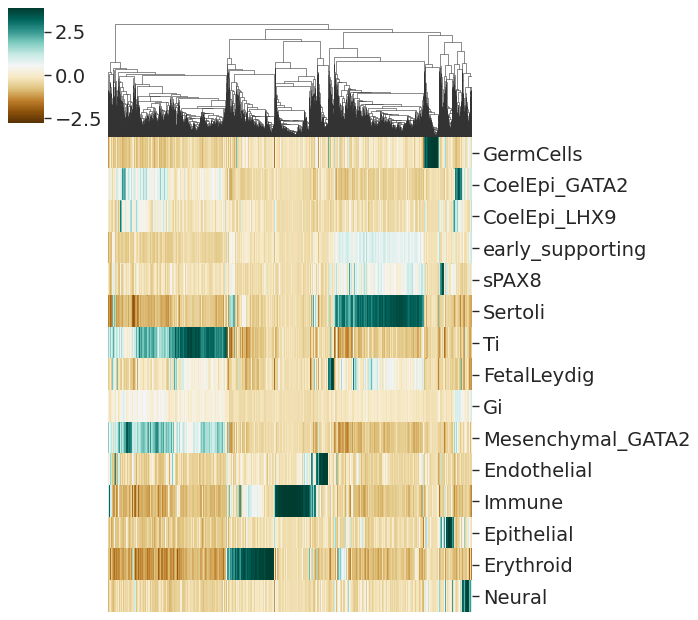

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.6)
heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(9, 8),
                         cmap = "BrBG")
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_males/heatmap_males_ccans_green.pdf")

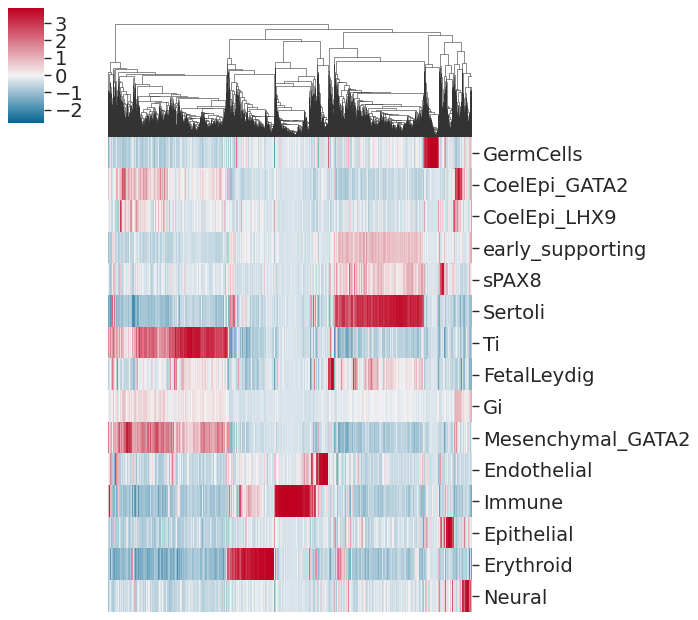

In [12]:
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.6)

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(9, 8),
                         cmap = my_cmap, norm = divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_males/heatmap_males_ccans_red.pdf")


### UMAP embedding of CCANs

In [38]:
# Create anndata 
celltype_CCANs_zscore_transposed = celltype_CCANs_zscore.transpose()
ccans_adata = anndata.AnnData(X = celltype_CCANs_zscore_transposed)
ccans_adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4177 × 12

In [39]:
sc.pp.neighbors(ccans_adata, random_state= 123)
sc.tl.umap(ccans_adata)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


In [40]:
ccans_adata.obs['female_value'] = ccans_adata.X.argmax(axis=1)

In [41]:
ccans_adata.obs['female_value'].value_counts(dropna = False)

11    734
0     476
2     470
10    459
8     421
5     375
9     340
7     320
4     311
3     188
1      55
6      28
Name: female_value, dtype: int64

In [42]:
supporting_cluster = {0 :'Germ cells', 1 :'coelEpi', 2:'ovarianSurf', 3:'preGC_I_OSR1',  4:'preGC_II_KITLG',
                            5:'preGC_III_GJA1', 6:'sPAX8', 7:'Oi', 8:'Gi', 9:'PV',
                            10:'Immune', 11:'Endothelial'}
ccans_adata.obs['clusters'] = ccans_adata.obs['female_value'].map(supporting_cluster)
ccans_adata.obs['clusters'].value_counts(dropna = False)

Endothelial       734
Germ cells        476
ovarianSurf       470
Immune            459
Gi                421
preGC_III_GJA1    375
PV                340
Oi                320
preGC_II_KITLG    311
preGC_I_OSR1      188
coelEpi            55
sPAX8              28
Name: clusters, dtype: int64

In [43]:
new_palette = ['saddlebrown', 'chocolate','red', 'darkorange', 'gold', 'olivedrab', 'forestgreen',  'limegreen', 
               'navy', 'dodgerblue', 'turquoise', 'paleturquoise',  'blueviolet', 'violet', 'hotpink', 'lightpink', 'slategray', 
              ]

... storing 'clusters' as categorical


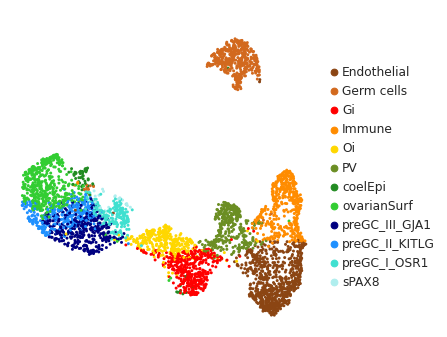

In [44]:
import seaborn as sns

sns.set(rc={'figure.figsize':(5,5), 'figure.facecolor':'white'})
gonads_colors = ['#c466b0','#e64e74',  '#60bddb', '#edb7b7', '#779eed', '#7b9e99',  '#70ccbe', 
                  '#91bd80', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
                  '#e08b8b', '#edb7b7', '#d9abb7','#aad3f2', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb']

sc.pl.umap(ccans_adata, color = 'clusters', title = " ", frameon = False,  outline_color = ('black', 'white'),
           palette = new_palette)


<AxesSubplot:>

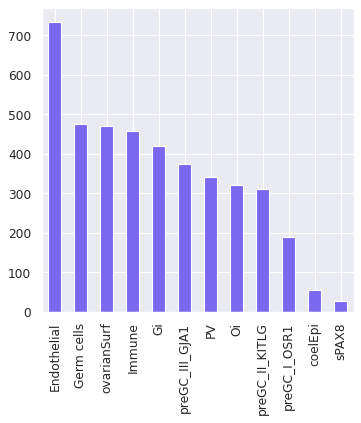

In [45]:
ccans_adata.obs['clusters'].value_counts().plot(kind='bar', figsize=(5, 5), rot=90, color = 'mediumslateblue')

In [46]:
peaks_mapping_numbers = {}
for k in peaks_mapping:
    peaks_mapping_numbers[str(k)] = len(peaks_mapping[k])

In [47]:
ccans_adata.obs['n_peaks'] = ccans_adata.obs_names.map(peaks_mapping_numbers)

In [48]:
plot_dict = {}
for i in np.unique(ccans_adata.obs['clusters']):
    print(i)
    plot_dict[i] = 0
    for index, row in ccans_adata.obs[ccans_adata.obs['clusters']==i].iterrows():
        plot_dict[i] += row['n_peaks']

Endothelial
Germ cells
Gi
Immune
Oi
PV
coelEpi
ovarianSurf
preGC_III_GJA1
preGC_II_KITLG
preGC_I_OSR1
sPAX8


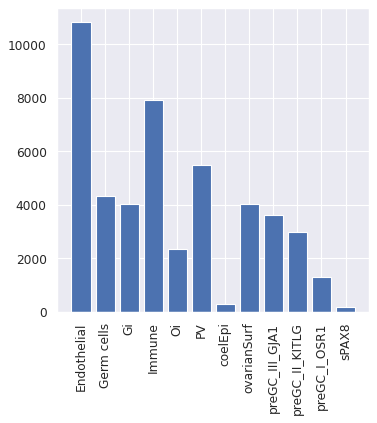

In [49]:
import matplotlib.pyplot as plt
plt.bar(range(len(plot_dict)), plot_dict.values(), align='center')
plt.xticks(range(len(plot_dict)), list(plot_dict.keys()), rotation = 90)

plt.show()

#### Show enrichment of CCAN containing 5 TFs that distinguish intra/extragonadal mesenchymal cells 

In [64]:
ccan_tf = ccans[ccans['gene_name'] == "ARX"]
ccan_tf

Peak  CCAN  peak_width  exon  \
peaks_formatted                                                          
chrX-25015376-25016172  chrX-25015376-25016172  8380         797     1   
chrX-25017051-25018131  chrX-25017051-25018131  8380        1081     0   

                                gene_id  gene gene_name annotation  promoter  \
peaks_formatted                                                                
chrX-25015376-25016172  ENSG00000004848     1       ARX       exon         1   
chrX-25017051-25018131  ENSG00000004848     0       ARX   promoter         1   

                        tss_distance  ENCODE_blacklist  
peaks_formatted                                         
chrX-25015376-25016172             0                 0  
chrX-25017051-25018131           630                 0

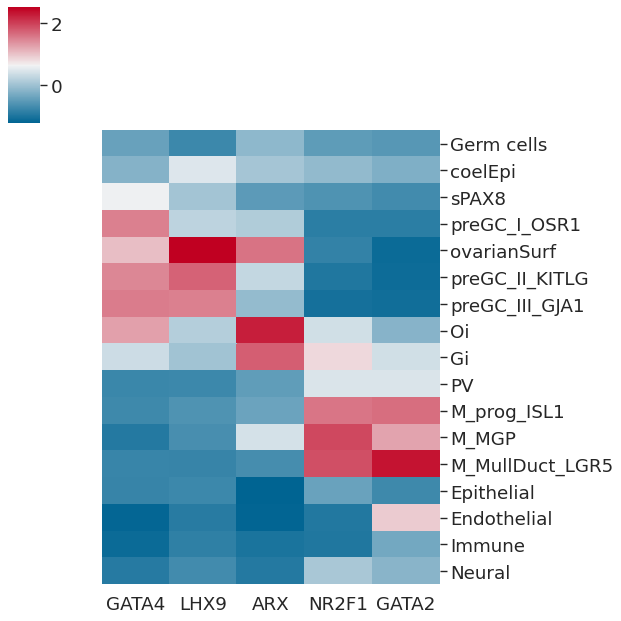

In [48]:
#### Select CCANs to plot 
tfs = ['7566', '273', '8380', '6518', '5104']
import seaborn as sns
import matplotlib.pyplot as plt
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.clustermap(celltype_CCANs_zscore[tfs], row_cluster=False, col_cluster = False, 
                         annot=False, xticklabels = [ 'GATA4', 'LHX9', 'ARX',  'NR2F1','GATA2'], yticklabels = "auto",  
                          figsize=(8, 8),
                         cmap = my_cmap)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_5TFs_ccans.pdf")

### Show enrichment of CCAN containing causal SNPs for PCOS 

In [44]:
celltype_CCANs_zscore = pd.read_csv(outdir + experiment_prefix + "_zscore_ccans.csv", index_col = 0)

In [45]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['Germ cells', 'coelEpi', 'sPAX8', 
                                                        'preGC_I_OSR1', 'ovarianSurf', 'preGC_II_KITLG',  'preGC_III_GJA1', 
                                                      'Oi', 'Gi', 'PV', 'M_prog_ISL1', 'M_MGP', 'M_MullDuct_LGR5', 
                                                       'Epithelial', 'Endothelial', 'Immune', 'Neural' ])


In [52]:
import pybedtools

In [53]:
## Save ccans as bed files 
for c in np.unique(ccans['CCAN']):
    ccan = ccans[ccans['CCAN'] == c]
    chrom = ccan['Peak'][1].split("-")[0] # Save chromosome information
    peaks = []
    for p in ccan['Peak'].to_list():
        p_start = p.split("-")[1]
        peaks.append(int(p_start))
        p_end = p.split("-")[2]
        peaks.append(int(p_end))
    peaks.sort()
    start = peaks[0]
    end = peaks[len(peaks)-1]
    #print("CCAN {}: {}-{}-{}".format(c, chrom, start, end))
    bed_dict = {'chrom' : chrom, 'chromStart' : start, 'chromEnd' : end}
    bed_df = pd.DataFrame(bed_dict, index=[0])
    pybedtools.BedTool.from_dataframe(bed_df, 
            outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/beds_ccans/" + "ccan_" + str(c) + ".bed", 
                                     index=False, sep='\t')

In [71]:
# Check CCAN:
ccans[ccans['CCAN'] == 6907]

Peak  CCAN  peak_width  exon  \
peaks_formatted                                                          
chr9-94668482-94669819  chr9-94668482-94669819  6907        1338     0   
chr9-94847138-94848127  chr9-94847138-94848127  6907         990     0   
chr9-94865118-94866413  chr9-94865118-94866413  6907        1296     0   
chr9-94950314-94951392  chr9-94950314-94951392  6907        1079     0   
chr9-95005923-95006625  chr9-95005923-95006625  6907         703     1   
chr9-95078590-95079596  chr9-95078590-95079596  6907        1007     0   
chr9-95101862-95102996  chr9-95101862-95102996  6907        1135     0   

                                gene_id  gene gene_name  annotation  promoter  \
peaks_formatted                                                                 
chr9-94668482-94669819              NaN     0       NaN  intergenic         0   
chr9-94847138-94848127  ENSG00000148120     1    C9orf3      intron         0   
chr9-94865118-94866413  ENSG00000148120     1    C9orf3      intron         0   
chr9-94950314-94951392  ENSG00000148120     1    C9orf3      intron         0   
chr9-95005923-95006625  ENSG00000148120     1    C9orf3        exon         0   
chr9-95078590-95079596  ENSG00000148120     1    C9orf3      intron         0   
chr9-95101862-95102996  ENSG00000158169     1     FANCC      intron         0   

                        tss_distance  ENCODE_blacklist  
peaks_formatted                                         
chr9-94668482-94669819         28232                 0  
chr9-94847138-94848127         72087                 0  
chr9-94865118-94866413         53801                 0  
chr9-94950314-94951392          4553                 0  
chr9-95005923-95006625           825                 0  
chr9-95078590-95079596          6424                 0  
chr9-95101862-95102996         15840                 0

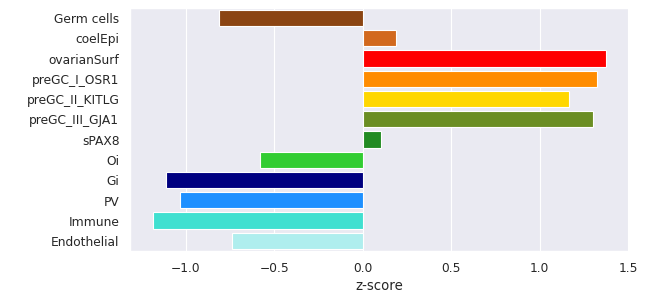

In [75]:
# 6907 (AOPEP) --> 3 SNPs
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6907], y = celltype_CCANs_zscore.index, 
            palette = new_palette, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6914.pdf")

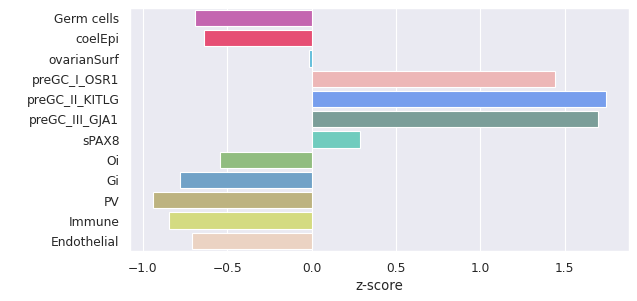

In [81]:
# 6387 --> 1 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6387], y = celltype_CCANs_zscore.index, 
            palette = gonads_colors, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6387.pdf")

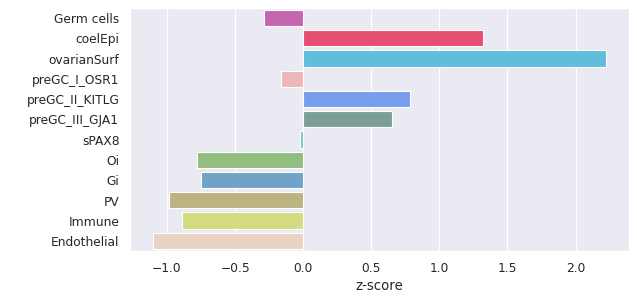

In [79]:
# 6679 (DENND1A) --> 3 SNPs
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6679], y = celltype_CCANs_zscore.index, 
            palette = gonads_colors, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6679.pdf")

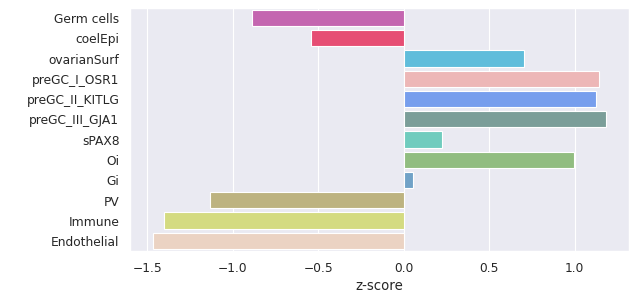

In [83]:
# 6333 --> 1 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6333], y = celltype_CCANs_zscore.index, 
            palette = gonads_colors, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6333.pdf")

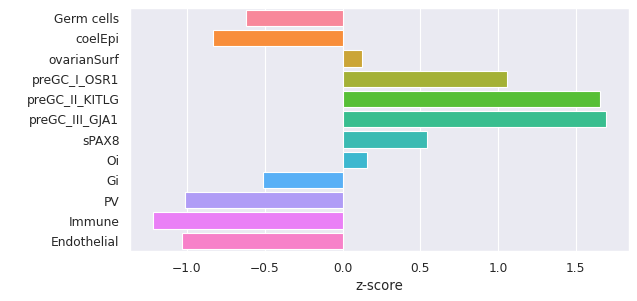

In [11]:
# 1614 --> 2 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['1614'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_1614.pdf")

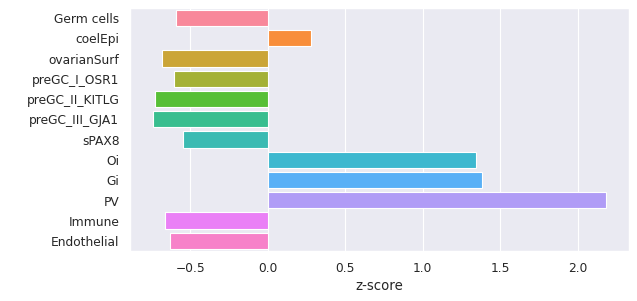

In [12]:
# 1637 --> 1 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['1637'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_1637.pdf")

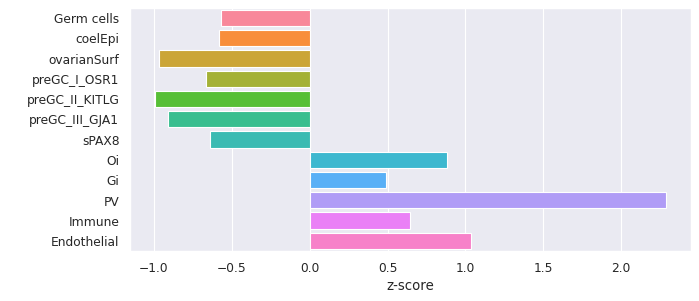

In [13]:
# 1662 --> 2 SNPs
sns.set(rc={'figure.figsize':(9,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['1662'], y = celltype_CCANs_zscore.index, 
           saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_1662.pdf")

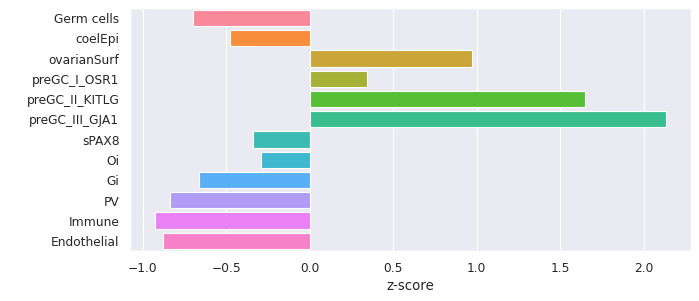

In [14]:
# 2512 --> 2 SNPs
sns.set(rc={'figure.figsize':(9,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['2512'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_2512.pdf")

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

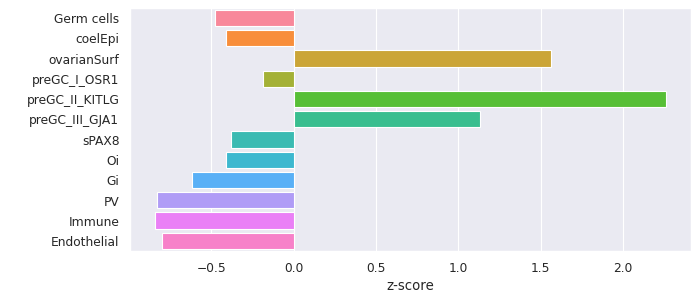

In [40]:
# ADGRB3: 6565
sns.set(rc={'figure.figsize':(9,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['84'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
#pcos_barplot.figure.savefig("_pcos_CCAN_ADGRB3.pdf")

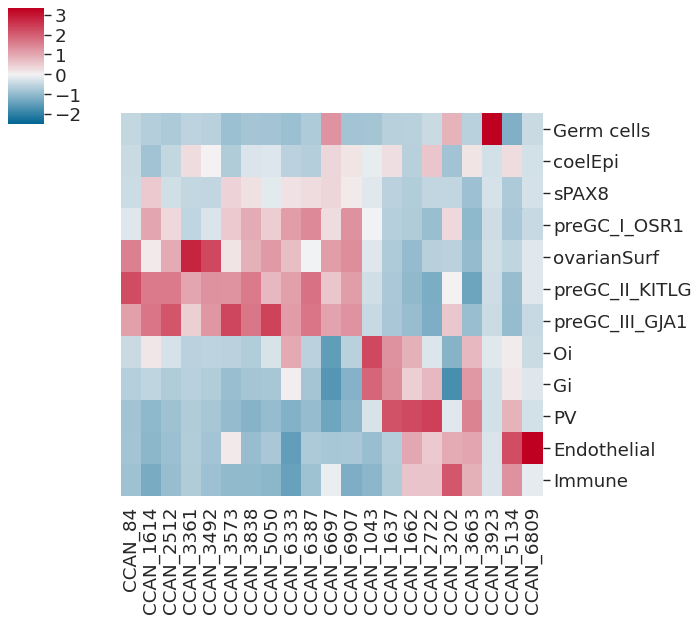

In [43]:
#### Select CCANs to plot 
tfs = ['84', '1614', '2512', '3361', '3492', '3573', '3838', '5050', '6333', '6387', '6697', '6907',
      '1043', '1637', '1662', '2722', '3202', '3663', '3923', '5134', '6809']
import seaborn as sns
import matplotlib.pyplot as plt
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)

heatmap = sns.clustermap(celltype_CCANs_zscore[tfs], row_cluster=False, col_cluster = False, 
                         annot=False, xticklabels = ['CCAN_84', 'CCAN_1614', 'CCAN_2512', 'CCAN_3361',
                           'CCAN_3492', 'CCAN_3573', 'CCAN_3838', 'CCAN_5050', 'CCAN_6333',
                               'CCAN_6387', 'CCAN_6697', 'CCAN_6907',
                        'CCAN_1043', 'CCAN_1637', 'CCAN_1662', 'CCAN_2722', 'CCAN_3202',
                          'CCAN_3663', 'CCAN_3923',  'CCAN_5134', 'CCAN_6809'], yticklabels = "auto",  
                          figsize=(9, 8),norm = divnorm,
                         cmap = my_cmap)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_PCOS_ccans_intragonadal.pdf")

## Save peaks as BED files

In [54]:
# Make a dictionary mapping cell type to set of CCANs enriched in that cell type  
cell_ccan_mapping = ccans_adata.obs.groupby('clusters').groups
#cell_ccan_mapping

In [55]:
peaks_mapping[1]

Index(['chr1-100354898-100355232', 'chr1-100357386-100358485',
       'chr1-100360562-100361182', 'chr1-100364418-100365076',
       'chr1-100469186-100469953'],
      dtype='object', name='peaks_formatted')

In [56]:
# Create a list of lists containing the peaks associated to each cell type
cell_types = ['Germ cells','coelEpi', 'ovarianSurf','preGC_I_OSR1',  'preGC_II_KITLG',
                                                       'preGC_III_GJA1','sPAX8', 'Oi', 'Gi', 'PV', 
                                                      'Immune', 'Endothelial']
big_list = []
for cell_type in cell_types: 
    ccan_list = list(cell_ccan_mapping[cell_type])
    cell_type_peaks = []
    for ccan in ccan_list: 
        ccan_int = int(ccan)
        ccan_peaks = list(peaks_mapping[ccan_int])
        cell_type_peaks.extend(ccan_peaks)
    print("{}: {} associated CCANs --> {} peaks".format(cell_type, len(ccan_list), 
                                                                                  len(cell_type_peaks)))
    big_list.append(cell_type_peaks)

Germ cells: 476 associated CCANs --> 4308 peaks
coelEpi: 55 associated CCANs --> 294 peaks
ovarianSurf: 470 associated CCANs --> 4026 peaks
preGC_I_OSR1: 188 associated CCANs --> 1288 peaks
preGC_II_KITLG: 311 associated CCANs --> 2995 peaks
preGC_III_GJA1: 375 associated CCANs --> 3604 peaks
sPAX8: 28 associated CCANs --> 157 peaks
Oi: 320 associated CCANs --> 2359 peaks
Gi: 421 associated CCANs --> 4035 peaks
PV: 340 associated CCANs --> 5499 peaks
Immune: 459 associated CCANs --> 7922 peaks
Endothelial: 734 associated CCANs --> 10838 peaks


In [57]:
# Remove peaks belonging to sex chromosomes X and Y 
big_list_somatic = []
for sublist in big_list: 
    sublist_somatic = [i for i in sublist if "X" not in i and "Y" not in i]
    big_list_somatic.append(sublist_somatic)

In [58]:
# Create a dataframe for each cell type containing chrom, chromStart, chromEnd for each peak 
bed_df_list = []
for sublist_somatic in big_list_somatic: 
    chrom = [i.split("-")[0] for i in sublist_somatic] # need to remove chr prefix
    chromStart = [int(i.split("-")[1]) for i in sublist_somatic]
    chromEnd = [int(i.split("-")[2]) for i in sublist_somatic]
    bed_dict = {'chrom' : chrom, 'chromStart' : chromStart, 'chromEnd' : chromEnd}
    bed_df = pd.DataFrame(bed_dict)
    #bed_df = bed_df.set_index('chrom')
    bed_df_list.append(bed_df)

In [59]:
len(bed_df_list)

12

In [60]:
import pybedtools

In [61]:
for idx in range(12):
    cell_type = cell_types[idx]
    print(cell_type)
    bed_df = bed_df_list[idx]
    if cell_type == "Germ cells":
         pybedtools.BedTool.from_dataframe(bed_df, 
            outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/beds_intragonadal/" + "GermCells" + ".bed", 
                                     index=False, sep='\t')
    else:
        pybedtools.BedTool.from_dataframe(bed_df, 
                outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/beds_intragonadal/" + cell_type + ".bed", 
                                     index=False, sep='\t')

Germ cells
coelEpi
ovarianSurf
preGC_I_OSR1
preGC_II_KITLG
preGC_III_GJA1
sPAX8
Oi
Gi
PV
Immune
Endothelial


#### End of notebook